# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Activate the created virtual environment
conda activate cs4220

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install torch                         # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [2]:
# import packages
import numpy as np
import pandas as pd
import timeit
import time
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from itertools import combinations
import glob  # import glob module

In [3]:
# Check the current working directory

%pwd

'/Users/cindyyu/Desktop/CS4220/PROJECT_2'

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [4]:
label_df = pd.read_csv('./training_data/train_labels.csv')
label_df['species_name'].value_counts()

species_name
homo_sapiens                       400027
burkholderia_pseudomallei            3540
pseudomonas_aeruginosa               3111
mycobacterium_ulcerans               3024
klebsiella_michiganensis             3010
bacillus_cereus                      2889
klebsiella_pneumoniae                2799
escherichia_coli                     2760
serratia_liquefaciens                2685
vibrio_parahaemolyticus              2572
stenotrophomonas_maltophilia         2524
salmonella_enterica_typhimurium      2491
yersinia_enterocolitica              2271
mycobacterium_tuberculosis           2173
clostridioides_difficile             2020
acinetobacter_baumannii              2005
legionella_pneumophila               1674
listeria_monocytogenes               1487
enterococcus_faecium                 1467
corynebacterium_striatum             1437
staphylococcus_aureus                1392
staphylococcus_haemolyticus          1298
staphylococcus_pseudintermedius      1254
corynebacterium_dipht

It seems that we have a lot of decoy reads (decoy means sequencing reads from human or commensal species).

In [5]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (25 classes - pathogens and decoy)

le = preprocessing.LabelEncoder()
le.fit(label_df['species_name'].unique())
y_index = le.transform(label_df['species_name'].values)
label_df['labels'] = y_index

We are not training using the full dataset to provide a quick baseline here. Thus, we subsampled so that each category has 500 reads. Up to you to come up with interesting training strategies to use your full training dataset (or even your own datasets)!

In [6]:
samples_index = label_df.groupby('labels').sample(500).index
samples_index

Index([  1833,   1945,    323,    187,    230,    944,   1241,    598,   1855,
         1467,
       ...
       464783, 464716, 464028, 464708, 465019, 463368, 463807, 464464, 463190,
       465013],
      dtype='int64', length=18500)

In this project, we try to use canonical $k$-mer profiles to represent each read in the input. Here, we are using $k=6$ and consequently 2081 features (including 1 feature `IGNORE` for ambiguous $k$-mer) for each read. Read [this reference](https://bioinfologics.github.io/post/2018/09/17/k-mer-counting-part-i-introduction/) for more information.

To help you save time, we implemented a utility class `CS4220Dataset` that can
- take in raw reads as input (`.fasta`, `.fa` files), and turn them into $k$-mer profiles, or
- take in $k$-mer profile as input (`.npy` files),
- allow you to sample data or create $k$-mer profile on the fly (during training) to save memory.

In [7]:
# Load dictionary that maps k-mer to their corresponding index.
# A k-mer and its reverse complement are mapped to the same index.
# We use k=6 here as an example.

import json

with open("./training_data/8-mers.json", 'r') as dict_file:
    canonical_kmer_dict = json.load(dict_file)

In [8]:
# We define a utility function here that turns sequences to their 6-mer profiles.

def sequence_to_kmer_profile(sequence : str, k : int = 8, count : bool = True):
    """
    Return the k-mer profile of the input sequence (string)
    """
    res = np.zeros(len(set(canonical_kmer_dict.values())))
    for i in range(len(sequence) - k + 1):
        k_mer = sequence[i:i + k]
        if k_mer in canonical_kmer_dict:
            res[canonical_kmer_dict[k_mer]] += 1
        else:
            res[-1] += 1

    if count == True:
        res /= np.sum(res)

    return res

In [9]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

input_file_path = './training_data/train_raw_reads.fasta'

class CS4220Dataset(Dataset):
    def __init__(self, data_file, label_df=None, k=8, samples_index=None, kmer_profile_on_the_fly=False, dtype=np.float32, count = True):
        """
        Dataset class to load large CS4220 sequence database.

        Args:
            - data_file (`str`): Can either be a *.fasta file if the input is raw reads, or *.npy file
                                 if the input is k-mer profile.
            - label_df (`pd.DataFrame` or `None`): A dataframe with "labels" column indicating the label
                                                   of the data (must match with data_file), or `None` if there is
                                                   no label (in the case of test sets).
            - k (`int`): The lengt of k-mer. We use 6 in this project.
            - samples_index (`List` or `None`): list of indices of data we sample from the data file. You
                                                can use this if the dataset is very large and can't fit in memory.
                                                set this to `None` if you want to use all the data.
            - kmer_profile_on_the_fly (`bool`): If input data_file is raw reads and this set to `True`,
                                                we will build k-mer profile on the fly. This is helpful if you want to
                                                alter the input sequences during training, or the k-mer profile can't fit in memory.
                                                Otherwise, we build k-mer profile in advance, which will speed up the
                                                training process.
            - dtype: type to store the k-mer profile. You may use, for example, `np.float32` for better precision,
                     or `np.float16` for smaller memory usage. If loaded from ".npy" file, it is always `np.float16`.
        """
        self.data_file = data_file

        if ".fasta" in data_file or ".fa" in data_file or ".fna" in data_file:
            self.is_raw_reads = True
        elif ".npy" in data_file:
            self.is_raw_reads = False
        else:
            raise TypeError(f"The input file must be either a fasta file containing raw reads (.fasta, .fa, .fna) or a numpy file containing k-mer profiles (.npy).")


        self.label_df = label_df
        self.kmer_profile_otf = kmer_profile_on_the_fly

        # k-mer length, set to be 6.
        self.k = k

        self.count = count

        # the samples we take from the read dataset
        self.samples_index = samples_index

        self.dtype = dtype

        # Load the data and store in self.reads and self.labels
        self.X = []
        self.Y = []
        self._read_labels()
        self._read_data()


    def _read_labels(self):
        """
        Read the labels and record them in self.labels.
        """
        if self.label_df is None:
            self.Y = None
        elif self.samples_index is None:
            # Load the whole dataset
            self.Y = list(self.label_df["labels"])
        else:
            # Load only the data corresponding to the sampled index
            self.Y = list(self.label_df.iloc[self.samples_index]["labels"])


    def _read_data(self):
        if self.is_raw_reads:
            # Read the fasta file
            with open(self.data_file, 'r') as fasta_file:
                lines = fasta_file.readlines()

            read_range = self.samples_index if self.samples_index is not None else range(int(len(lines) / 2))
            if not self.kmer_profile_otf:
                self.X = np.zeros(
                    (len(read_range), len(set(canonical_kmer_dict.values()))),
                    dtype=self.dtype
                )

            for i, j in enumerate(tqdm(read_range, desc=f"Parsing fasta file {self.data_file}")):
                read = lines[j * 2 + 1].strip()
                if self.kmer_profile_otf:
                    # If chose to do k-mer profiling on the fly, simply store the reads
                    self.X.append(read)
                else:
                    # Otherwise, do k-mer profiling during training/testing, cost more time during training/testing
                    self.X[i, :] = sequence_to_kmer_profile(read, self.k, self.count)
        else:
            # Read the .npy file, and load the numpy matrix
            # Each row corresponds to a read, and each column corresponds to a k-mer (see training_data/6-mers.txt).
            self.X = np.load(self.data_file)
            if self.samples_index is not None:
                self.X = self.X[self.samples_index, :]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        """
        If you are using pytorch, this function helps taking data points during each epoch
        of your training.
        """
        x = self.X[idx]
        if self.kmer_profile_otf:
            read_tensor = torch.tensor(sequence_to_kmer_profile(x, self.k, self.count), dtype=self.dtype)
        else:
            read_tensor = torch.tensor(x)

        label = self.Y[idx] if self.Y is not None else None
        return read_tensor, label




In [10]:
fasta_list = []
directory = './reference_genome/'  # set directory path
for filename in glob.iglob(f'{directory}/*.fasta'):  
    fasta_list.append(str(filename))


In [11]:
def kmer_count_fasta(input_path: str, k: int = 8): #for getting kmer counts of specific fasta file
    data = CS4220Dataset(input_path, k = k, count = False)
    
    #df of kmer count totals only
    data_kmer = pd.DataFrame(data.X) #gives 0/1 per position for each kmer
    return(data_kmer.sum()) #gives count per col, which is 8-mer type

In [12]:
k = 4
for k in range(4, 9):
    with open("./training_data/"+str(k)+"-mers.json", 'r') as dict_file:
        canonical_kmer_dict = json.load(dict_file)

    for file in fasta_list:
        profile = kmer_count_fasta(file, k)
        profiledf = pd.DataFrame(profile)

        file_name = file + str(k) + 'mer.csv'
        profiledf.to_csv(file_name, sep='\t')


Parsing fasta file ./reference_genome/staphylococcus_pseudintermedius.fasta:   0%|          | 0/16018 [00:00<?, ?it/s]

Parsing fasta file ./reference_genome/staphylococcus_pseudintermedius.fasta: 100%|██████████| 16018/16018 [00:01<00:00, 15744.60it/s]
Parsing fasta file ./reference_genome/bacillus_cereus.fasta: 100%|██████████| 36483/36483 [00:02<00:00, 18079.68it/s]
Parsing fasta file ./reference_genome/klebsiella_michiganensis.fasta: 100%|██████████| 37763/37763 [00:02<00:00, 14742.76it/s]
Parsing fasta file ./reference_genome/streptococcus_salivarius.fasta: 100%|██████████| 13817/13817 [00:01<00:00, 12982.01it/s]
Parsing fasta file ./reference_genome/streptococcus_suis.fasta: 100%|██████████| 13569/13569 [00:00<00:00, 16317.66it/s]
Parsing fasta file ./reference_genome/klebsiella_pneumoniae.fasta: 100%|██████████| 35519/35519 [00:02<00:00, 12355.15it/s]
Parsing fasta file ./reference_genome/escherichia_coli.fasta: 100%|██████████| 34969/34969 [00:02<00:00, 16444.93it/s]
Parsing fasta file ./reference_genome/corynebacterium_diphtheriae.fasta: 100%|██████████| 15398/15398 [00:00<00:00, 16514.94it/s]


KeyboardInterrupt: 

In [13]:
#get csv list
k = 6

csv_list = []
directory = './reference_genome/'+str(k)+'MER_CSV'  # set directory path

for filename in glob.iglob(f'{directory}/*.csv'):  
    csv_list.append(str(filename))


clean_csv_list = [csv.replace('./reference_genome/'+str(k)+'MER_CSV/', '').replace('.fasta'+str(k)+'mer.csv', '') for csv in csv_list]

In [14]:
#read files into a list of dataframes
dfs = [pd.read_csv(file, sep = "\t", index_col=0) for file in csv_list]

#all possible unique combinations of 2 files
pairs = list(combinations(range(len(dfs)), 2))  # Indices for pairs

merged_dfs = []
#loop through pairs and merge the corresponding dataframes
for i, j in pairs:
    species1 = clean_csv_list[i]
    species2 = clean_csv_list[j]

    #merging dfs 
    merged_df = pd.merge(dfs[i], dfs[j], left_index=True, right_index=True) 
    merged_df = merged_df.rename(columns={'0_x': species1, '0_y': species2})

    #creating normalized col (not counts)
    merged_df[species1 + 'norm'] = merged_df[species1]/(merged_df[species1].sum())
    merged_df[species2 + 'norm'] = merged_df[species2]/(merged_df[species2].sum())  
    
    #summing for eventual jaccard index, count
    merged_df["max count"] = merged_df[[species1, species2]].max(axis = 1)
    merged_df["min count"] = merged_df[[species1, species2]].min(axis = 1)

    #summing for eventual jaccard index, norm
    merged_df["max norm"] = merged_df[[species1 + 'norm', species2 + 'norm']].max(axis = 1)
    merged_df["min norm"] = merged_df[[species1 + 'norm', species2 + 'norm']].min(axis = 1)
    
    merged_dfs.append(merged_df)
   
   #for writing, not super needed
   #merged_df.to_csv('merged'+clean_csv_list[i]+clean_csv_list[j]+'.csv', index=False)

#adds max/min columns of rows extrema
#also add a column for "normalization" of counts (aka divide by sum so we can compare that as well)

In [15]:
jaccard_list = pd.DataFrame(columns=['species_1', 'species_2', "jaccard_count", "jaccard_norm", "jaccard_diff"])

for df in merged_dfs:
    #note the max+min serves as denominator, min serves as common aka numerator
    #count
    denom_count = df["max count"].sum()
    num_count = df["min count"].sum()

    #norm
    denom_norm = df["max norm"].sum()
    num_norm = df["min norm"].sum()

    jaccard_list.loc[-1] = [df.columns.values[0], df.columns.values[1], num_count/denom_count, num_norm/denom_norm, num_count/denom_count - num_norm/denom_norm]
    jaccard_list.index = jaccard_list.index + 1



In [17]:
jaccard_list = jaccard_list.sort_values("jaccard_count")

jaccard_list.to_csv('SupplementaryMaterial2.csv')




In [ ]:
jaccard_list.to_csv("jaccard_"+str(k)+"mer.csv")

In [ ]:
#get jaccard lists into dictionary from reading
jaccards = {}

for k in range(4,9):
    path = './jaccard_'+str(k)+'mer.csv'  # set directory path
    df = pd.read_csv(path, index_col=0)
    jaccards[k] = df


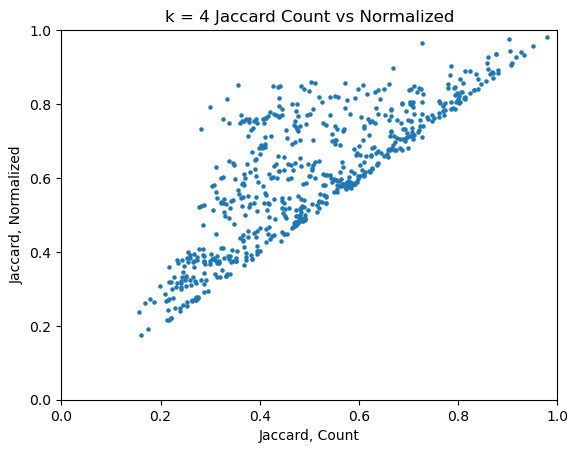

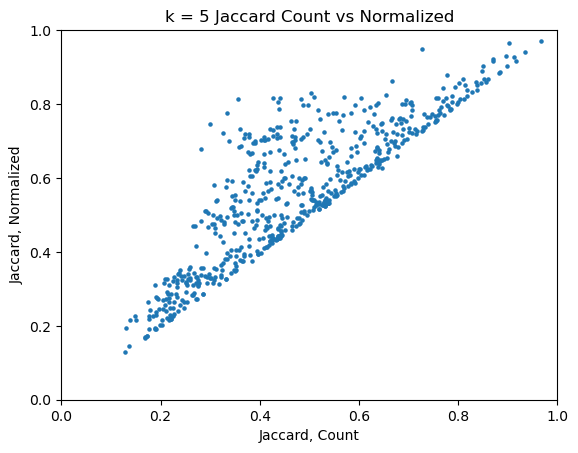

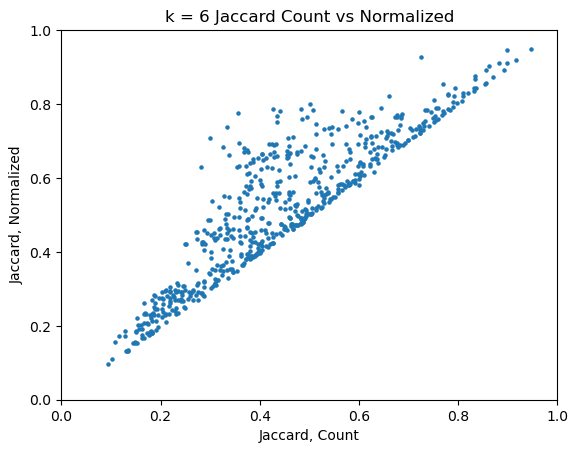

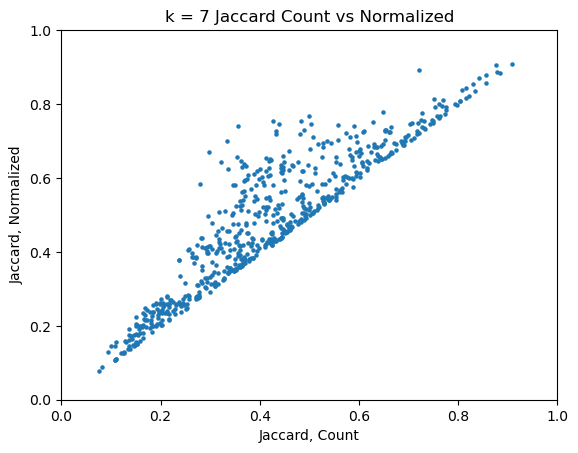

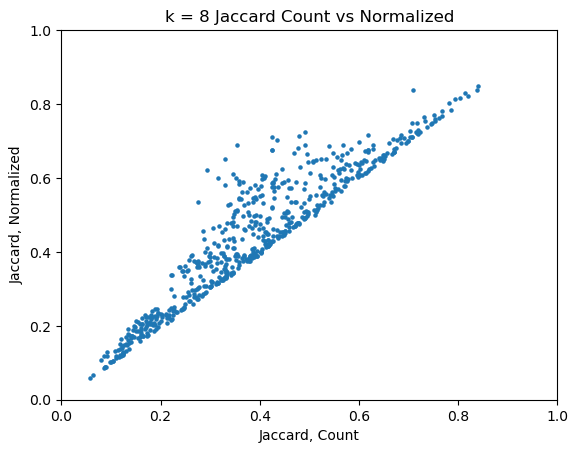

In [ ]:
for k in range(4, 9):
       fig, ax = plt.subplots()
       ax.scatter(jaccards[k]['jaccard_count'], jaccards[k]["jaccard_norm"], s=5)

       ax.set(xlim=(0, 1),
              ylim=(0, 1))
       
       plt.title('k = ' + str(k)+' Jaccard Count vs Normalized')
       plt.xlabel("Jaccard, Count")
       plt.ylabel("Jaccard, Normalized")

       plt.show()



In [ ]:
#8 ONLY FOR BELOW CODE
jaccards[8][(jaccards[8]["jaccard_count"] > 0.635)]



,species_1,species_2,jaccard_count,jaccard_norm,jaccard_diff
355,corynebacterium_striatum,corynebacterium_ulcerans,0.639927,0.653033,-0.013106
495,staphylococcus_pseudintermedius,enterococcus_faecium,0.642599,0.649443,-0.006844
540,mycobacterium_tuberculosis,stenotrophomonas_maltophilia,0.644267,0.652663,-0.008396
34,staphylococcus_aureus,listeria_monocytogenes,0.647524,0.645856,0.001668
360,corynebacterium_striatum,corynebacterium_diphtheriae,0.647579,0.663017,-0.015438
451,enterococcus_faecium,legionella_pneumophila,0.650424,0.661916,-0.011492
581,yersinia_enterocolitica,salmonella_enterica_typhimurium,0.650609,0.650801,-0.000191
629,vibrio_parahaemolyticus,yersinia_enterocolitica,0.652790,0.660460,-0.007669
126,legionella_pneumophila,listeria_monocytogenes,0.655984,0.668252,-0.012268
52,streptococcus_agalactiae,staphylococcus_haemolyticus,0.659777,0.693644,-0.033867


In [ ]:
#filters by similarity, takes species pairs only
#0.635 FOR 8
similar = {}

for k in range(4,9):
    similar[k] = jaccards[k][(jaccards[k]["jaccard_count"] > 0.635)]
    similar[k] = similar[k][['species_1', 'species_2']]

    print(similar[k].shape)


(148, 2)
(129, 2)
(97, 2)
(82, 2)
(56, 2)


In [ ]:
#MERGE JACCARD SIMILARITIES TO SEE COMMANLITIES
#all possible unique combinations of 2 files
pairs = list(combinations(range(4,9), 2))

merged_similar = {}

for i, j in pairs:
    df = pd.merge(similar[i], similar[j], on=['species_1', 'species_2'], how='inner')
    tuple = (i, j)
    merged_similar[tuple] = df



In [ ]:
merge_similar_jaccard = pd.DataFrame(columns=['pair', 'common', 'denom', "jaccard"])

for key, value in merged_similar.items():
    common = len(value.index)

    #values of tuple, aka which k = ?
    k1 = key[0]
    k2 = key[1]

    denom = len(similar[k1].index) + len(similar[k2].index)

    merge_similar_jaccard.loc[-1] = [key, common, denom, common/denom ]
    merge_similar_jaccard.index = merge_similar_jaccard.index + 1


In [ ]:
merge_similar_jaccard 

,pair,common,denom,jaccard
9,"(4, 5)",62,352,0.176136
8,"(4, 6)",103,326,0.315951
7,"(4, 7)",35,302,0.115894
6,"(4, 8)",81,277,0.292419
5,"(5, 6)",42,296,0.141892
4,"(5, 7)",86,272,0.316176
3,"(5, 8)",31,247,0.125506
2,"(6, 7)",40,246,0.162602
1,"(6, 8)",72,221,0.325792
0,"(7, 8)",26,197,0.131980


In [ ]:
jaccards[k][(jaccards[k]["jaccard_count"] > 0.635)]

,species_1,species_2,jaccard_count,jaccard_norm,jaccard_diff
355,corynebacterium_striatum,corynebacterium_ulcerans,0.639927,0.653033,-0.013106
495,staphylococcus_pseudintermedius,enterococcus_faecium,0.642599,0.649443,-0.006844
540,mycobacterium_tuberculosis,stenotrophomonas_maltophilia,0.644267,0.652663,-0.008396
34,staphylococcus_aureus,listeria_monocytogenes,0.647524,0.645856,0.001668
360,corynebacterium_striatum,corynebacterium_diphtheriae,0.647579,0.663017,-0.015438
451,enterococcus_faecium,legionella_pneumophila,0.650424,0.661916,-0.011492
581,yersinia_enterocolitica,salmonella_enterica_typhimurium,0.650609,0.650801,-0.000191
629,vibrio_parahaemolyticus,yersinia_enterocolitica,0.652790,0.660460,-0.007669
126,legionella_pneumophila,listeria_monocytogenes,0.655984,0.668252,-0.012268
52,streptococcus_agalactiae,staphylococcus_haemolyticus,0.659777,0.693644,-0.033867


In [ ]:

import networkx as nx
#https://networkx.org/documentation/stable/tutorial.html
groups = {}

#COPY FROM ABOVE
#filters by similarity, takes species pairs only
similar = {}

for k in range(4,9):
    similar[k] = jaccards[k][(jaccards[k]["jaccard_count"] > 0.635)]
    similar[k] = similar[k][['species_1', 'species_2']]

    print(similar[k].shape)


for k in range(4,9):
    # create a graph from the pairs
    G = nx.Graph()
    G.add_edges_from(similar[k].values)

    # Find connected components (groups)
    groups[k] = [sorted(list(comp)) for comp in nx.connected_components(G)]
    
groups[8] #.39 threshold includes all the genus groups



(148, 2)
(129, 2)
(97, 2)
(82, 2)
(56, 2)


[['corynebacterium_diphtheriae',
  'corynebacterium_striatum',
  'corynebacterium_ulcerans'],
 ['acinetobacter_baumannii',
  'enterococcus_faecium',
  'legionella_pneumophila',
  'listeria_monocytogenes',
  'staphylococcus_aureus',
  'staphylococcus_epidermidis',
  'staphylococcus_haemolyticus',
  'staphylococcus_pseudintermedius',
  'staphylococcus_pyogenes',
  'streptococcus_agalactiae',
  'streptococcus_anginosus',
  'streptococcus_mitis',
  'streptococcus_pneumoniae',
  'streptococcus_salivarius',
  'streptococcus_suis'],
 ['mycobacterium_tuberculosis',
  'mycobacterium_ulcerans',
  'pseudomonas_aeruginosa',
  'stenotrophomonas_maltophilia'],
 ['escherichia_coli',
  'klebsiella_michiganensis',
  'klebsiella_pneumoniae',
  'salmonella_enterica_typhimurium',
  'serratia_liquefaciens',
  'vibrio_parahaemolyticus',
  'yersinia_enterocolitica'],
 ['neisseria_gonorrhoeae', 'neisseria_lactamica']]

In [ ]:
#type(groups[8][0])
import csv

with open("groups"+str(8)+".csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(groups[8])




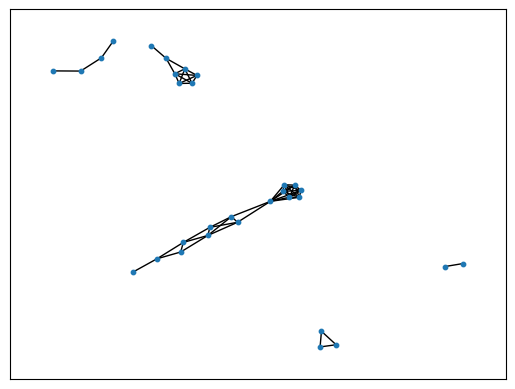

In [ ]:
G = nx.Graph()
G.add_edges_from(similar[8].values)
nx.draw_networkx(G, with_labels = False, node_size = 10)

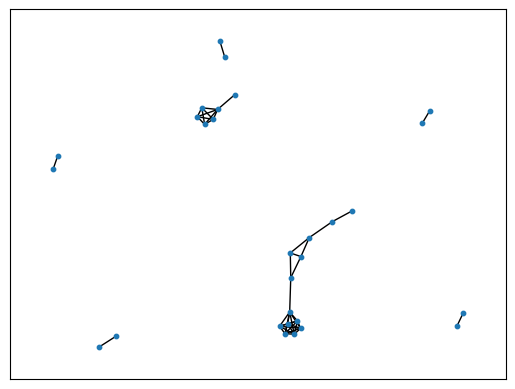

In [ ]:
G = nx.Graph()
G.add_edges_from(similar[8].values)
nx.draw_networkx(G, with_labels = False, node_size = 10)

The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

### TRAINING

In [ ]:
# Example usage, getting k = 8
# if use raw reads as inputs/change label df for groups
input_file_path = './training_data/train_raw_reads.fasta'
sampled_dataset = CS4220Dataset(input_file_path, label_df, k=8, samples_index=samples_index)

Parsing fasta file ./training_data/train_raw_reads.fasta: 100%|██████████| 18500/18500 [02:29<00:00, 123.94it/s]


In [ ]:
label_df

,species_name,labels
0,acinetobacter_baumannii,0
1,acinetobacter_baumannii,0
2,acinetobacter_baumannii,0
3,acinetobacter_baumannii,0
4,acinetobacter_baumannii,0
...,...,...
465019,yersinia_enterocolitica,36
465020,yersinia_enterocolitica,36
465021,yersinia_enterocolitica,36
465022,yersinia_enterocolitica,36


In [69]:
with open("groups"+str(8)+".csv", "r") as file:
    reader = csv.reader(file)
    groups_loaded = [row for row in reader]

groups_loaded

[['corynebacterium_diphtheriae',
  'corynebacterium_striatum',
  'corynebacterium_ulcerans'],
 ['acinetobacter_baumannii',
  'enterococcus_faecium',
  'legionella_pneumophila',
  'listeria_monocytogenes',
  'staphylococcus_aureus',
  'staphylococcus_epidermidis',
  'staphylococcus_haemolyticus',
  'staphylococcus_pseudintermedius',
  'staphylococcus_pyogenes',
  'streptococcus_agalactiae',
  'streptococcus_anginosus',
  'streptococcus_mitis',
  'streptococcus_pneumoniae',
  'streptococcus_salivarius',
  'streptococcus_suis'],
 ['mycobacterium_tuberculosis',
  'mycobacterium_ulcerans',
  'pseudomonas_aeruginosa',
  'stenotrophomonas_maltophilia'],
 ['escherichia_coli',
  'klebsiella_michiganensis',
  'klebsiella_pneumoniae',
  'salmonella_enterica_typhimurium',
  'serratia_liquefaciens',
  'vibrio_parahaemolyticus',
  'yersinia_enterocolitica'],
 ['neisseria_gonorrhoeae', 'neisseria_lactamica']]